## Importing and prepping data

In [1]:
import pandas as pd

import diff_classifier.aws as aws
import diff_classifier.pca as pca

import os
import diff_classifier.imagej as ij
import boto3
import os.path as op
import diff_classifier.aws as aws
import diff_classifier.knotlets as kn
import numpy as np
from sklearn.externals import joblib

In [2]:
features = []
#featofvar = 'Type and Serum'

remote_folder = 'Cell_Studies/10_16_18_cell_study' #Folder in AWS S3 containing files to be analyzed
bucket = 'ccurtis.data'
vids = 5
types = ['PS', 'PEG']
slices = [1, 2]
extras = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1']

counter = 0
for typ in types:
    for slic in slices:
        for num in range(1, vids+1):
            try:
                filename = 'features_{}_{}_XY{}.csv'.format(typ, slic, num)
                print(filename)
                aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
                fstats = pd.read_csv(filename, encoding = "ISO-8859-1")
                
                for extra in extras:
                    fstats[extra] = fstats.index
                fstats = fstats.drop(extras, axis=1)
                
                print('{} size: {}'.format(filename, fstats.shape))
                if 'PS' in typ:
                    fstats['Type'] = pd.Series(fstats.shape[0]*['COOH'], index=fstats.index)
                else:
                    fstats['Type'] = pd.Series(fstats.shape[0]*['PEG'], index=fstats.index)
                fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
                fstats['Well Number'] = pd.Series(fstats.shape[0]*[slic], index=fstats.index)
                counter = counter + 1
                if counter == 1:
                    fstats_tot = fstats
                else:
                    fstats_tot = fstats_tot.append(fstats, ignore_index=True)
            except:
                print('Skipped!: {}'.format(filename))

features_PS_1_XY1.csv
features_PS_1_XY1.csv size: (17215, 72)
features_PS_1_XY2.csv
features_PS_1_XY2.csv size: (36025, 72)
features_PS_1_XY3.csv
features_PS_1_XY3.csv size: (27995, 72)
features_PS_1_XY4.csv
features_PS_1_XY4.csv size: (31375, 72)
features_PS_1_XY5.csv
features_PS_1_XY5.csv size: (25037, 72)
features_PS_2_XY1.csv
features_PS_2_XY1.csv size: (13730, 72)
features_PS_2_XY2.csv
features_PS_2_XY2.csv size: (10992, 72)
features_PS_2_XY3.csv
features_PS_2_XY3.csv size: (18088, 72)
features_PS_2_XY4.csv
features_PS_2_XY4.csv size: (27814, 72)
features_PS_2_XY5.csv
features_PS_2_XY5.csv size: (21126, 72)
features_PEG_1_XY1.csv
features_PEG_1_XY1.csv size: (14422, 72)
features_PEG_1_XY2.csv
features_PEG_1_XY2.csv size: (10203, 72)
features_PEG_1_XY3.csv
features_PEG_1_XY3.csv size: (12272, 72)
features_PEG_1_XY4.csv
features_PEG_1_XY4.csv size: (15135, 72)
features_PEG_1_XY5.csv
features_PEG_1_XY5.csv size: (14631, 72)
features_PEG_2_XY1.csv
features_PEG_2_XY1.csv size: (12991, 

In [3]:
type_status = ['{} {}'.format(type_, status_) for type_, status_ in zip(fstats_tot['Type'].tolist(), fstats_tot['Cell Status'].tolist())]

In [4]:
fstats_tot['Type and Status'] = pd.Series(type_status, index=fstats_tot.index)

In [ ]:
#PCA analyses with too many datapoints fail. You get rows with lots of NAs. I'm going to try making a subset of the data first
#and then do a PCA analysis on that.

#include all in analysis
import random
subset = np.sort(np.array(random.sample(range(fstats_tot.shape[0]), 500000)))
fstats_sub = fstats_tot.loc[subset, :].reset_index(drop=True)

In [ ]:
fstats_tot['Type'].unique()

In [ ]:
for typ in fstats_tot['Type'].unique():
    fstats_type = fstats_tot[fstats_tot['Type']==typ].reset_index(drop=True)
    print(fstats_type.shape)

In [5]:
#with equal sample sizes for each particle type
nonnum = ['Type', 'Well Number', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y', 'Cell Status', 'Cell Distance', 'Membrane Xing', 'Distance Towards Cell',
          'Percent Towards Cell', 'Type and Status']

import random
counter = 0
for typ in fstats_tot['Type'].unique():
    fstats_type = fstats_tot[fstats_tot['Type']==typ].reset_index(drop=True)
    print(fstats_type.shape)
    subset = np.sort(np.array(random.sample(range(fstats_type.shape[0]), 100000)))
    if counter == 0:
        fstats_sub = fstats_type.loc[subset, :].reset_index(drop=True)
    else:
        fstats_sub = fstats_sub.append(fstats_type.loc[subset, :].reset_index(drop=True), ignore_index=True)
    counter = counter + 1

(229397, 76)
(132788, 76)


In [6]:
#fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
fstats_num = fstats_sub.drop(nonnum, axis=1)
fstats_raw = fstats_num.as_matrix()
#fstats

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [7]:
ncomp = 13
pcadataset = pca.pca_analysis(fstats_tot, dropcols=nonnum, n_components=ncomp)

Cumulative explained variance:
0 component: 0.3577965231582651
1 component: 0.46901798794447647
2 component: 0.5416462944225237
3 component: 0.593107282717595
4 component: 0.6300335505343613
5 component: 0.6660270898866314
6 component: 0.6954394811748651
7 component: 0.7204496915754265
8 component: 0.7425524715997835
9 component: 0.7635628010560408
10 component: 0.7818815291867071
11 component: 0.7989433425843775
12 component: 0.8153961671511777


In [8]:
pcadataset.components.to_csv('components.csv')
aws.upload_s3('components.csv', '{}/components.csv'.format(remote_folder, filename), bucket_name=bucket)

In [9]:
fstats_num.columns

Index(['AR', 'D_fit', 'Deff1', 'Deff2', 'MSD_ratio', 'Mean AR', 'Mean D_fit',
       'Mean Deff1', 'Mean Deff2', 'Mean MSD_ratio', 'Mean Quality',
       'Mean SN_Ratio', 'Mean alpha', 'Mean asymmetry1', 'Mean asymmetry2',
       'Mean asymmetry3', 'Mean boundedness', 'Mean efficiency',
       'Mean elongation', 'Mean fractal_dim', 'Mean frames', 'Mean kurtosis',
       'Mean straightness', 'Mean trappedness', 'Mean_Intensity', 'Quality',
       'SN_Ratio', 'Std AR', 'Std D_fit', 'Std Deff1', 'Std Deff2',
       'Std MSD_ratio', 'Std Quality', 'Std SN_Ratio', 'Std alpha',
       'Std asymmetry1', 'Std asymmetry2', 'Std asymmetry3', 'Std boundedness',
       'Std efficiency', 'Std elongation', 'Std fractal_dim', 'Std frames',
       'Std kurtosis', 'Std straightness', 'Std trappedness', 'alpha',
       'asymmetry1', 'asymmetry2', 'asymmetry3', 'boundedness', 'efficiency',
       'elongation', 'fractal_dim', 'frames', 'kurtosis', 'straightness',
       'trappedness'],
      dtype='object

In [10]:
pcadataset.prcomps

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Mean straightness,asymmetry3,asymmetry2,Mean SN_Ratio,boundedness,Std elongation,straightness,D_fit,Std AR,kurtosis,Std Deff2,Std straightness,kurtosis
1,Mean efficiency,Mean asymmetry1,asymmetry1,SN_Ratio,trappedness,Std asymmetry3,D_fit,Std MSD_ratio,Mean AR,D_fit,Mean Deff2,kurtosis,Std kurtosis
2,Mean Deff1,Mean asymmetry2,efficiency,Std asymmetry1,alpha,Std asymmetry2,efficiency,boundedness,Std MSD_ratio,Deff1,Deff2,Mean alpha,Deff2
3,Mean D_fit,asymmetry2,asymmetry3,Mean elongation,MSD_ratio,Std asymmetry1,alpha,trappedness,Mean MSD_ratio,Deff2,Std MSD_ratio,Std Deff2,frames
4,Mean fractal_dim,elongation,elongation,Quality,asymmetry2,Std straightness,boundedness,Mean MSD_ratio,SN_Ratio,Std AR,kurtosis,Std alpha,fractal_dim


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [8]:
kmostat = pca.kmo(pcadataset.scaled)

0.943971677235


In [ ]:
import scipy.stats as stat
stat.bartlett(pcadataset.scaled[0, :], pcadataset.scaled[1, :], pcadataset.scaled[2, :], pcadataset.scaled[3, :])

In [ ]:
newstr = ''
for i in range(pcadataset.scaled.shape[0]-1):
    newstr = newstr + 'pcadataset.scaled[{}, :], '.format(i)

newstr = 'stat.bartlett(' + newstr + 'pcadataset.scaled[{}, :])'.format(i+1)

In [ ]:
test = eval(newstr)

In [ ]:
test

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [11]:
import numpy as np
featofvar = 'Type'
#ncomp = 14
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='COOH'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='PEG'].values[:, -ncomp:], axis=0)

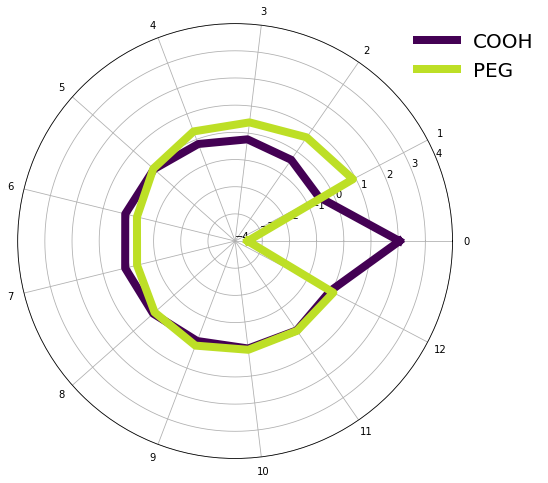

In [12]:
labels = ['COOH', 'PEG']
pca.plot_pca(dicti, savefig=True, labels=labels, rticks=np.linspace(-4, 4, 9))

In [13]:
import numpy as np
featofvar = 'Type and Status'
#ncomp = 14
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='PEG False'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='COOH False'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='PEG True'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='COOH True'].values[:, -ncomp:], axis=0)

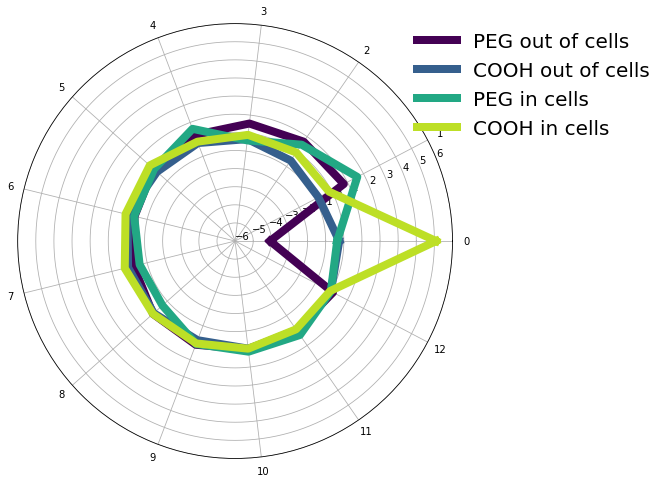

In [14]:
labels2 = ['PEG out of cells', 'COOH out of cells', 'PEG in cells', 'COOH in cells']
pca.plot_pca(dicti, savefig=True, labels=labels2, rticks=np.linspace(-6, 6, 13))

In [15]:
import diff_classifier.heatmaps as hm
import matplotlib.pyplot as plt

In [ ]:
substats = pcadataset.final[(pcadataset.final['Video Number']==1) & (pcadataset.final['Well Number']==1) &
                            (pcadataset.final['Type']=='PEG')]
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(substats['X'], substats['Y'], c=substats['Cell Status'], s=5)
plt.show()

In [ ]:
pcadataset.final['Type and Cell'] = pcadataset.final['Type'] + ' ' + pcadataset.final['Cell Status'].map(str)

In [ ]:
pcadataset.final.head()

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

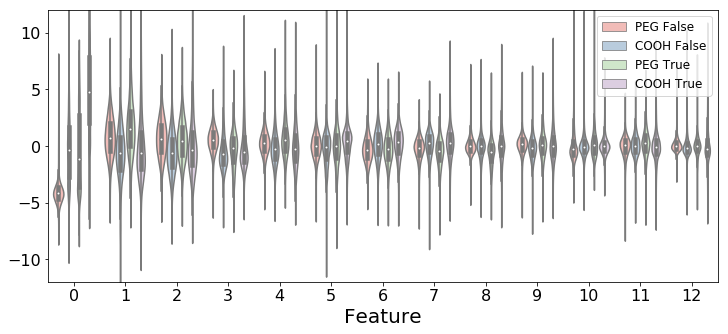

In [16]:
labels=['PEG False', 'COOH False', 'PEG True', 'COOH True']
featofvar = 'Type and Status'
feats = pca.feature_violin(pcadataset.final, label=featofvar, lvals=labels, fsubset=ncomp, yrange=[-12, 12])

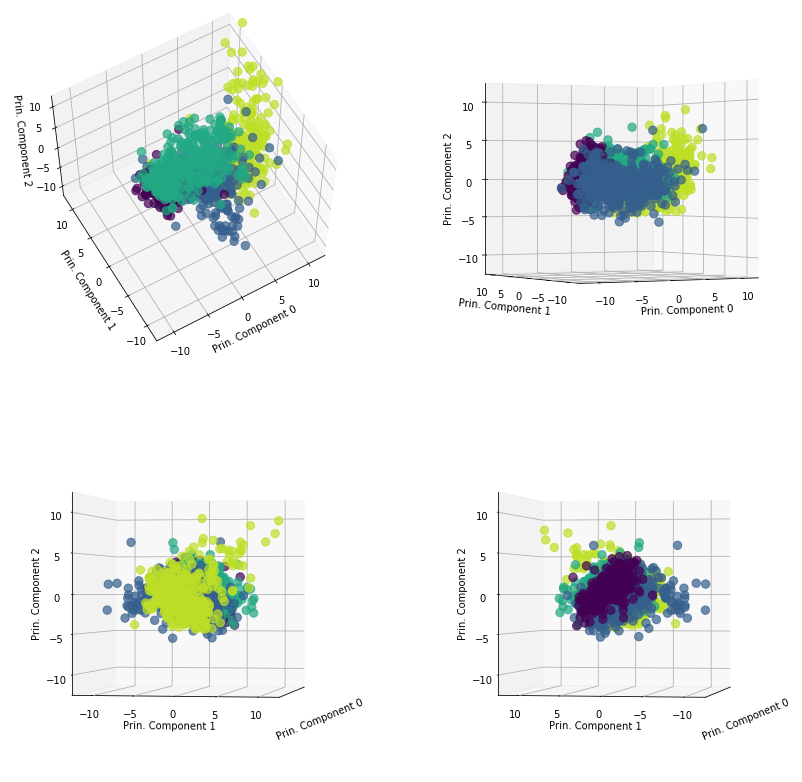

In [17]:
fstats1 = pca.feature_plot_3D(pcadataset.final, label=featofvar, lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12])

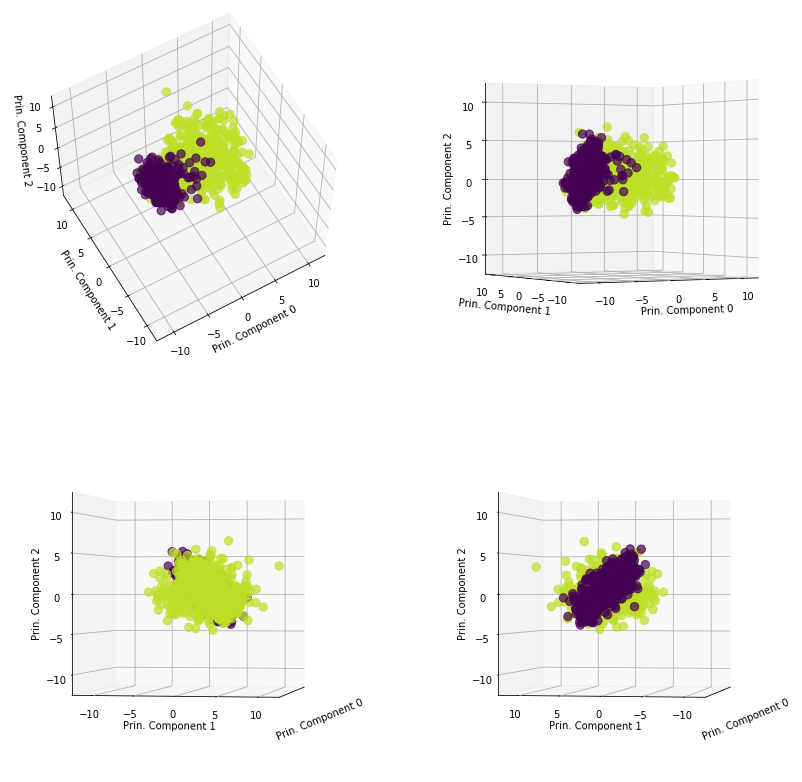

In [18]:
labels1 = ['PEG False', 'PEG True']
fstats1 = pca.feature_plot_3D(pcadataset.final[pcadataset.final['Type']=='PEG'], label=featofvar, lvals=labels1, randcount=800, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12])

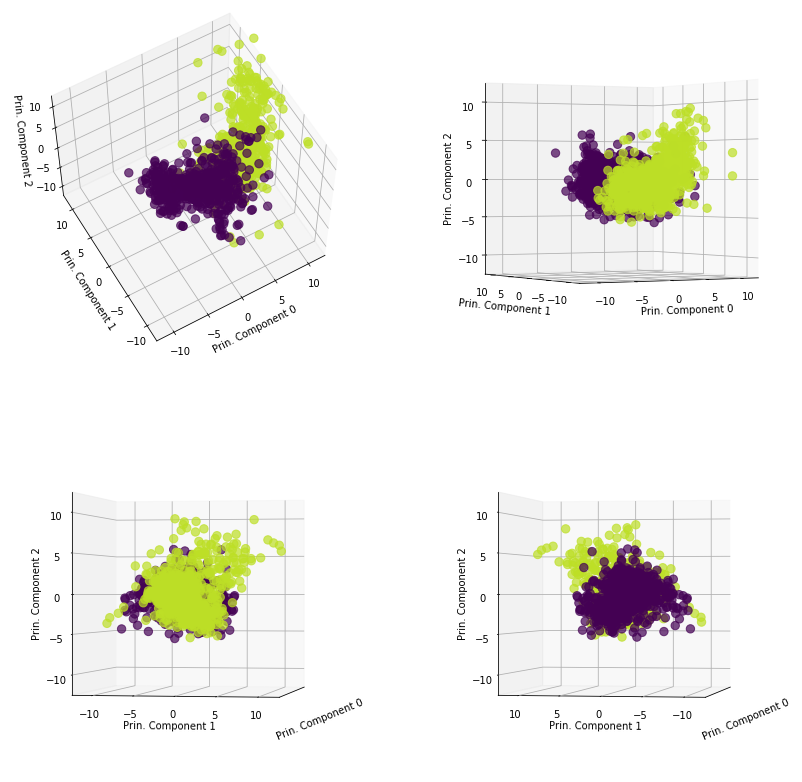

In [19]:
labels1 = ['COOH False', 'COOH True']
fstats1 = pca.feature_plot_3D(pcadataset.final[pcadataset.final['Type']=='COOH'], label=featofvar, lvals=labels1, randcount=800, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12])

In [ ]:
#ncomp = 14
trainp = np.array([])
testp = np.array([])
#labels3 = ['low', 'hi']

for i in range(0, 20):
    KNNmod, X, y = pca.build_model(pcadataset.final, featofvar, labels, equal_sampling=True,
                                       tsize=1000, input_cols=ncomp, model='MLP', NNhidden_layer=(6, 5, 3))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final[featofvar].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

In [ ]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

In [ ]:
#ncomp = 14
labels1 = ['COOH False', 'COOH True']
trainp = np.array([])
testp = np.array([])
#labels3 = ['low', 'hi']

for i in range(0, 10):
    KNNmod, X, y = pca.build_model(pcadataset.final[pcadataset.final[featofvar].isin(labels1)], featofvar, labels1, equal_sampling=True,
                                       tsize=1000, input_cols=ncomp, model='MLP', NNhidden_layer=(10, 6, 5, 3))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final[pcadataset.final[featofvar].isin(labels1)].values[:, -ncomp:]
    y2 = pcadataset.final[pcadataset.final[featofvar].isin(labels1)][featofvar].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

In [ ]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

In [ ]:
#ncomp = 14
labels1 = ['PEG False', 'PEG True']
trainp = np.array([])
testp = np.array([])
#labels3 = ['low', 'hi']

for i in range(0, 10):
    KNNmod, X, y = pca.build_model(pcadataset.final[pcadataset.final[featofvar].isin(labels1)], featofvar, labels1, equal_sampling=True,
                                       tsize=1000, input_cols=ncomp, model='MLP', NNhidden_layer=(10, 6, 5, 3))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final[pcadataset.final[featofvar].isin(labels1)].values[:, -ncomp:]
    y2 = pcadataset.final[pcadataset.final[featofvar].isin(labels1)][featofvar].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

In [ ]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

In [12]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [21]:
ncomp = 13
#featofvar = 'Region and Type'
test = pcadataset.final.values[:, -ncomp:]
y = pcadataset.final[featofvar].values
for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(600, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.51057342
Validation score: 0.813961
Iteration 2, loss = 0.47632506
Validation score: 0.816216
Iteration 3, loss = 0.46389625
Validation score: 0.819667
Iteration 4, loss = 0.45460969
Validation score: 0.820495
Iteration 5, loss = 0.44681403
Validation score: 0.830296
Iteration 6, loss = 0.44056549
Validation score: 0.831631
Iteration 7, loss = 0.43444055
Validation score: 0.832919
Iteration 8, loss = 0.42992721
Validation score: 0.832735
Iteration 9, loss = 0.42511076
Validation score: 0.834208
Iteration 10, loss = 0.42059693
Validation score: 0.844009
Iteration 11, loss = 0.41699578
Validation score: 0.842582
Iteration 12, loss = 0.41308744
Validation score: 0.841846
Iteration 13, loss = 0.41069912
Validation score: 0.846632
Iteration 14, loss = 0.40771497
Validation score: 0.839960
Iteration 15, loss = 0.40517892
Validation score: 0.845987
Iteration 16, loss = 0.40174691
Validation score: 0.847230
Iteration 17, loss = 0.39875851
Validation score: 0.848794
Iterat

Text(0,0.5,'Validation Scores')

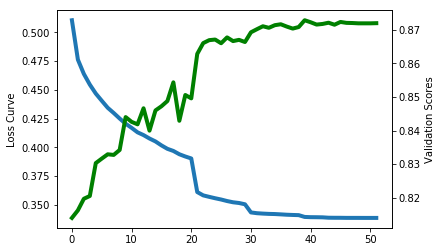

In [22]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(clf.loss_curve_, linewidth=4)
#ax1.set_xlim([0, 60])
#ax1.set_ylim([0.04, 0.18])
ax1.set_ylabel('Loss Curve')

ax2 = ax1.twinx()
ax2.plot(clf.validation_scores_, linewidth=4, c='g')
#ax2.set_ylim([0.65, 0.75])
ax2.set_ylabel('Validation Scores')

In [23]:
test = pcadataset.final[pcadataset.final['Type']=='COOH'].values[:, -ncomp:]
y = pcadataset.final[pcadataset.final['Type']=='COOH']['Cell Status'].values
for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(600, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.34244102
Validation score: 0.848373
Iteration 2, loss = 0.32522022
Validation score: 0.853894
Iteration 3, loss = 0.31881926
Validation score: 0.853822
Iteration 4, loss = 0.31313921
Validation score: 0.857527
Iteration 5, loss = 0.30735630
Validation score: 0.858253
Iteration 6, loss = 0.30187047
Validation score: 0.862249
Iteration 7, loss = 0.29632672
Validation score: 0.869006
Iteration 8, loss = 0.29139708
Validation score: 0.866318
Iteration 9, loss = 0.28657914
Validation score: 0.871404
Iteration 10, loss = 0.28258729
Validation score: 0.867844
Iteration 11, loss = 0.27861943
Validation score: 0.871476
Iteration 12, loss = 0.27472200
Validation score: 0.877507
Iteration 13, loss = 0.27163151
Validation score: 0.878596
Iteration 14, loss = 0.26792038
Validation score: 0.876853
Iteration 15, loss = 0.26414193
Validation score: 0.881139
Iteration 16, loss = 0.26104537
Validation score: 0.877434
Iteration 17, loss = 0.25828470
Validation score: 0.885716
Iterat

Text(0,0.5,'Validation Scores')

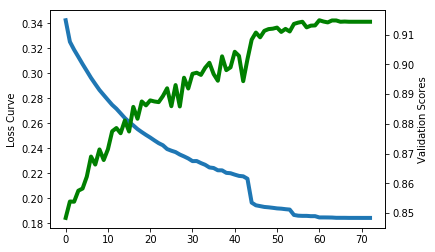

In [24]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(clf.loss_curve_, linewidth=4)
#ax1.set_xlim([0, 60])
#ax1.set_ylim([0.04, 0.18])
ax1.set_ylabel('Loss Curve')

ax2 = ax1.twinx()
ax2.plot(clf.validation_scores_, linewidth=4, c='g')
#ax2.set_ylim([0.65, 0.75])
ax2.set_ylabel('Validation Scores')

In [25]:
test = pcadataset.final[pcadataset.final['Type']=='PEG'].values[:, -ncomp:]
y = pcadataset.final[pcadataset.final['Type']=='PEG']['Cell Status'].values
for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(800, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=100, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.27214276
Validation score: 0.909513
Iteration 2, loss = 0.26088439
Validation score: 0.911521
Iteration 3, loss = 0.25872455
Validation score: 0.911898
Iteration 4, loss = 0.25712888
Validation score: 0.912023
Iteration 5, loss = 0.25587446
Validation score: 0.912776
Iteration 6, loss = 0.25490334
Validation score: 0.912149
Iteration 7, loss = 0.25405674
Validation score: 0.912776
Iteration 8, loss = 0.25340909
Validation score: 0.913027
Iteration 9, loss = 0.25277406
Validation score: 0.913027
Iteration 10, loss = 0.25215622
Validation score: 0.913153
Iteration 11, loss = 0.25168533
Validation score: 0.911898
Iteration 12, loss = 0.25131064
Validation score: 0.912149
Iteration 13, loss = 0.25050172
Validation score: 0.912651
Validation score did not improve more than tol=0.000010 for two consecutive epochs. Setting learning rate to 0.001000
Iteration 14, loss = 0.24965656
Validation score: 0.912149
Iteration 15, loss = 0.24927676
Validation score: 0.913027
Iterat

Text(0,0.5,'Validation Scores')

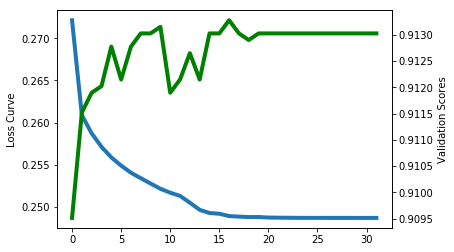

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(clf.loss_curve_, linewidth=4)
#ax1.set_xlim([0, 60])
#ax1.set_ylim([0.245, 0.265])
ax1.set_ylabel('Loss Curve')

ax2 = ax1.twinx()
ax2.plot(clf.validation_scores_, linewidth=4, c='g')
#ax2.set_ylim([0.90, 0.92])
ax2.set_ylabel('Validation Scores')

In [ ]:
test = pcadataset.final[pcadataset.final['Type']=='PEG'].values[:, -ncomp:]
y = pcadataset.final[pcadataset.final['Type']=='PEG']['Cell Status'].values
for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(800, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=100, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

In [15]:
test = pcadataset.final[np.abs(pcadataset.final['Cell Distance']) > 10].values[:, -ncomp:]
y = pcadataset.final[np.abs(pcadataset.final['Cell Distance']) > 10]['Type and Status'].values
for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(800, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=100, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.47792389
Validation score: 0.831188
Iteration 2, loss = 0.43674026
Validation score: 0.836228
Iteration 3, loss = 0.42360136
Validation score: 0.839571
Iteration 4, loss = 0.41486217
Validation score: 0.844411
Iteration 5, loss = 0.40788932
Validation score: 0.846956
Iteration 6, loss = 0.40172009
Validation score: 0.849601
Iteration 7, loss = 0.39623559
Validation score: 0.852944
Iteration 8, loss = 0.39077865
Validation score: 0.855938
Iteration 9, loss = 0.38583722
Validation score: 0.855888
Iteration 10, loss = 0.38152340
Validation score: 0.859980
Iteration 11, loss = 0.37659601
Validation score: 0.861277
Iteration 12, loss = 0.37240868
Validation score: 0.864222
Iteration 13, loss = 0.36819658
Validation score: 0.862475
Iteration 14, loss = 0.36443399
Validation score: 0.866717
Iteration 15, loss = 0.36065882
Validation score: 0.868014
Iteration 16, loss = 0.35736887
Validation score: 0.864721
Iteration 17, loss = 0.35391436
Validation score: 0.871507
Iterat

Text(0,0.5,'Validation Scores')

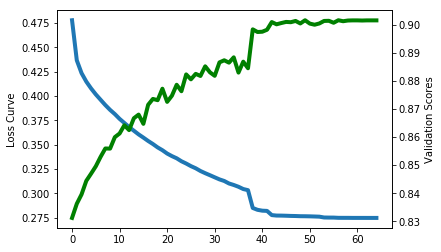

In [17]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(clf.loss_curve_, linewidth=4)
#ax1.set_xlim([0, 60])
#ax1.set_ylim([0.245, 0.265])
ax1.set_ylabel('Loss Curve')

ax2 = ax1.twinx()
ax2.plot(clf.validation_scores_, linewidth=4, c='g')
#ax2.set_ylim([0.90, 0.92])
ax2.set_ylabel('Validation Scores')

In [18]:
test = pcadataset.final[np.abs(pcadataset.final['Cell Distance']) > 20].values[:, -ncomp:]
y = pcadataset.final[np.abs(pcadataset.final['Cell Distance']) > 20]['Type and Status'].values
for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(800, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=100, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.43952616
Validation score: 0.853780
Iteration 2, loss = 0.39406742
Validation score: 0.858055
Iteration 3, loss = 0.38073923
Validation score: 0.860274
Iteration 4, loss = 0.37229033
Validation score: 0.862547
Iteration 5, loss = 0.36559275
Validation score: 0.864332
Iteration 6, loss = 0.36053388
Validation score: 0.867688
Iteration 7, loss = 0.35481894
Validation score: 0.870556
Iteration 8, loss = 0.35006475
Validation score: 0.872937
Iteration 9, loss = 0.34566216
Validation score: 0.873316
Iteration 10, loss = 0.34153690
Validation score: 0.876941
Iteration 11, loss = 0.33726580
Validation score: 0.875480
Iteration 12, loss = 0.33375316
Validation score: 0.878240
Iteration 13, loss = 0.33024685
Validation score: 0.878727
Iteration 14, loss = 0.32658532
Validation score: 0.879160
Iteration 15, loss = 0.32314525
Validation score: 0.881108
Iteration 16, loss = 0.32021167
Validation score: 0.880297
Iteration 17, loss = 0.31701002
Validation score: 0.882894
Iterat

Text(0,0.5,'Validation Scores')

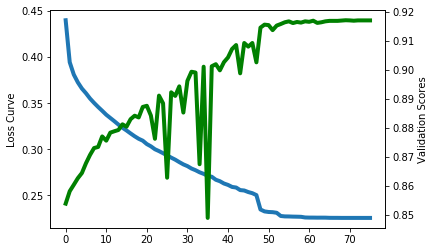

In [19]:
fig, ax1 = plt.subplots()
ax1.plot(clf.loss_curve_, linewidth=4)
#ax1.set_xlim([0, 60])
#ax1.set_ylim([0.245, 0.265])
ax1.set_ylabel('Loss Curve')

ax2 = ax1.twinx()
ax2.plot(clf.validation_scores_, linewidth=4, c='g')
#ax2.set_ylim([0.90, 0.92])
ax2.set_ylabel('Validation Scores')

In [ ]:
for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=100, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
def build_modelR(rawdata, feature, featvals, equal_sampling=True,
                    tsize=20, from_end=True, input_cols=6, model='KNN',
                    **kwargs):
    """Builds a K-nearest neighbor model using an input dataset.

    Parameters
    ----------
    rawdata : pandas.core.frames.DataFrame
        Raw dataset of n samples and p features.
    feature : string or int
        Feature in rawdata containing output values on which KNN
        model is to be based.
    featvals : string or int
        All values that feature can take.
    equal_sampling : bool
        If True, training dataset will contain an equal number
        of samples that take each value of featvals. If false,
        each sample in training dataset will be taken randomly
        from rawdata.
    tsize : int
        Size of training dataset. If equal_sampling is False,
        training dataset will be exactly this size. If True,
        training dataset will contain N x tsize where N is the
        number of unique values in featvals.
    n_neighbors : int
        Number of nearest neighbors to be used in KNN
        algorithm.
    from_end : int
        If True, in_cols will select features to be used as
        training data defined end of rawdata e.g.
        rawdata[:, -6:]. If False, input_cols will be read
        as a tuple e.g. rawdata[:, 10:15].
    input_col : int or tuple
        Defined in from_end above.

    Returns
    -------
    clf : sklearn.neighbors.classification.KNeighborsClassifier
        KNN model
    X : numpy.ndarray
        training input dataset used to create clf
    y : numpy.ndarray
        training output dataset used to create clf

    """

    defaults = {'NNsolver': 'adam', 'NNalpha': 1e-5,
                'NNhidden_layer': (5, 2), 'NNrandom_state': 1,
                'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
                }

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]
    
    if equal_sampling:
        for featval in featvals:
            if from_end:
                test = rawdata[rawdata[feature] == featval
                               ].values[:, -input_cols:]
            else:
                test = rawdata[rawdata[feature] == featval
                               ].values[:, input_cols[0]:input_cols[1]]
            to_plot = np.array(random.sample(range(0, test.shape[0]
                                                   ), tsize))
            if featval == featvals[0]:
                X = test[to_plot, :]
                y = rawdata[rawdata[feature] == featval
                            ][feature].values[to_plot]
            else:
                X = np.append(X, test[to_plot, :], axis=0)
                y = np.append(y, rawdata[rawdata[feature] == featval
                                         ][feature].values[to_plot], axis=0)

    else:
        if from_end:
            test = rawdata.values[:, -input_cols:]
        else:
            test = rawdata.values[:, input_cols[0]:input_cols[1]]
        to_plot = np.array(random.sample(range(0, test.shape[0]), tsize))
        X = test[to_plot, :]
        y = rawdata[feature].values[to_plot]

    if model is 'MLP':
        clf = MLPRegressor(solver=kwargs['NNsolver'], alpha=kwargs['NNalpha'],
                            hidden_layer_sizes=kwargs['NNhidden_layer'],
                            random_state=kwargs['NNrandom_state'],
                            beta_1=kwargs['beta_1'], beta_2=kwargs['beta_2'],
                            epsilon=kwargs['epsilon'])
    
        clf.fit(X, y)
        return clf, X, y

In [ ]:
labels2 = [0.4, 0.6, 0.8, 1.0, 1.2]

trainp = np.array([])
testp = np.array([])

for i in range(0, 20):
    MLPmod, X, y = build_modelR(pcadataset.final, 'Bulk Agarose Int', labels2, equal_sampling=True,
                                           tsize=1000, input_cols=ncomp, model='MLP', NNhidden_layer=(13, 11, 9, 7, 5, 3))
    trainp = np.append(trainp, MLPmod.score(X, y))

    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Bulk Agarose Int'].values
    testp = np.append(testp, MLPmod.score(X2, y2))
    print(testp[i])

In [ ]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y2, MLPmod.predict(X2), alpha=0.002)
x = np.linspace(0, 10, 11)
plt.plot(x, x, c='b', linewidth=1)
plt.ylim(0.4, 1.2)
plt.xlim(0.35, 1.25)
ticks = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]
plt.xticks(labels2)
plt.yticks(ticks)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y, MLPmod.predict(X), alpha=0.006)
x = np.linspace(0, 10, 11)
plt.plot(x, x, c='b', linewidth=1)
plt.ylim(0.4, 1.2)
plt.xlim(0.35, 1.25)
ticks = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]
plt.xticks(labels2)
plt.yticks(ticks)

In [ ]:
labelshort = [0.4, 0.6, 0.8, 1.0]
pcasub = pcadataset.final[pcadataset.final['Bulk Agarose Int'].isin(labelshort)]
trainp = np.array([])
testp = np.array([])

for i in range(0, 20):
    MLPmod, X, y = build_modelR(pcasub, 'Bulk Agarose Int', labelshort, equal_sampling=True,
                                           tsize=1000, input_cols=ncomp, model='MLP', NNhidden_layer=(13, 11, 9, 7, 5, 3))
    trainp = np.append(trainp, MLPmod.score(X, y))

    X2 = pcasub.values[:, -ncomp:]
    y2 = pcasub['Bulk Agarose Int'].values
    testp = np.append(testp, MLPmod.score(X2, y2))
    print(testp[i])

In [ ]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

In [ ]:
combos = [['0_8', '1_0']]
vids = 5

counter = 0
for combo in combos:
    for num in range(1, vids+1):

        filename = 'features_100x_{}_{}_gel_interface_vid_{}.csv'.format(combo[0], combo[1], num)
        aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
        fstats_new1 = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        #fstats['Percent Agarose'] = pd.Series(fstats.shape[0]*[str(visc[key])], index=fstats.index)
        #print(fstats_new.shape[0])
        fstats_new1['Video Number'] = pd.Series(fstats_new1.shape[0]*[num], index=fstats_new1.index)
        fstats_new1['Interface'] = pd.Series(fstats_new1.shape[0]*['{}/{}'.format(combo[0], combo[1])], index=fstats_new1.index)
        #print(num)
        print(filename)
        counter = counter + 1
        if counter == 1:
            fstats_tot1 = fstats_new1
        else:
            fstats_tot1 = fstats_tot1.append(fstats_new1, ignore_index=True)

In [ ]:
nonnum1 = ['Interface', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
fstats_num1 = fstats_tot1.drop(nonnum1, axis=1)
interf_data = pca.recycle_pcamodel(pcadataset.pcamodel, fstats_num1)
interf_data['Predicted'] = KNNmod.predict(interf_data[list(range(0, ncomp))])

for col in nonnum1:
    interf_data[col] = fstats_tot1[col]

num=2
rearr = feature_plot_2D(interf_data[interf_data['Video Number']==num],
                            label='Predicted', features=['X', 'Y'], randsel=False, dotsize=10,
                            lvals=['0_4', '1_2'], legendloc=2)

In [ ]:
nonnum1 = ['Interface', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
fstats_num1 = fstats_tot1.drop(nonnum1, axis=1)
interf_data = pca.recycle_pcamodel(pcadataset.pcamodel, fstats_num1)
interf_data['Predicted'] = KNNmod.predict(interf_data[list(range(0, ncomp))])

for col in nonnum1:
    interf_data[col] = fstats_tot1[col]

num=2
rearr = feature_plot_2D(interf_data[interf_data['Video Number']==num],
                            label='Predicted', features=['X', 'Y'], randsel=False, dotsize=10,
                            lvals=['0_4', '0_8'], legendloc=2)

In [ ]:
from matplotlib.pyplot import cm
nonnum1 = ['Interface', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
fstats_num1 = fstats_tot1.drop(nonnum1, axis=1)
interf_data = pca.recycle_pcamodel(pcadataset.pcamodel, fstats_num1)
interf_data['Predicted'] = KNNmod.predict(interf_data[list(range(0, ncomp))])

for col in nonnum1:
    interf_data[col] = fstats_tot1[col]

num=3
rearr = feature_plot_2D(interf_data[interf_data['Video Number']==num],
                            label='Predicted', features=['X', 'Y'], randsel=False, dotsize=10,
                            lvals=['0_6', '0_8'])

In [ ]:
nonnum1 = ['Interface', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
fstats_num1 = fstats_tot1.drop(nonnum1, axis=1)
interf_data = pca.recycle_pcamodel(pcadataset.pcamodel, fstats_num1)
interf_data['Predicted'] = KNNmod.predict(interf_data[list(range(0, ncomp))])

for col in nonnum1:
    interf_data[col] = fstats_tot1[col]

num=4
rearr = feature_plot_2D(interf_data[interf_data['Video Number']==num],
                            label='Predicted', features=['X', 'Y'], randsel=False, dotsize=10,
                            lvals=['0_8', '1_0'])

In [ ]:
def feature_plot_2D(dataset, label, features=[0, 1], lvals=['PEG', 'PS'],
                    randsel=True, randcount=200, **kwargs):

    defaults = {'figsize': (8, 8), 'dotsize': 70, 'alpha': 0.7, 'xlim': None,
                'ylim': None, 'legendfontsize': 12, 'labelfontsize': 20,
                'fname': None, 'legendloc': 2}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]

    tgroups = {}
    xy = {}
    counter = 0
    labels = dataset[label].unique()
    for lval in lvals:
        tgroups[counter] = dataset[dataset[label] == lval]
        counter = counter + 1

    N = len(tgroups)
    color = iter(cm.viridis(np.linspace(0, 0.9, N)))

    fig = plt.figure(figsize=kwargs['figsize'])
    ax1 = fig.add_subplot(111)
    counter = 0
    for key in tgroups:
        c = next(color)
        xy = []
        if randsel:
            to_plot = random.sample(range(0, len(tgroups[key][0].tolist())),
                                    randcount)
            for key2 in features:
                xy.append(list(tgroups[key][key2].tolist()[i] for i in to_plot))
        else:
            for key2 in features:
                xy.append(tgroups[key][key2])
        ax1 = plt.scatter(xy[0], xy[1], c=c, s=kwargs['dotsize'],
                          alpha=kwargs['alpha'], label=labels[counter])
        counter = counter + 1

    if kwargs['xlim'] is not None:
        plt.xlim(kwargs['xlim'])
    if kwargs['ylim'] is not None:
        plt.ylim(kwargs['ylim'])

    plt.legend(fontsize=kwargs['legendfontsize'], frameon=False,
               borderaxespad=0., loc=2,
               bbox_to_anchor=(1, 1))
    plt.xlabel('Prin. Component {}'.format(features[0]),
               fontsize=kwargs['labelfontsize'])
    plt.ylabel('Prin. Component {}'.format(features[1]),
               fontsize=kwargs['labelfontsize'])

    if kwargs['fname'] is None:
        plt.show()
    else:
        plt.savefig(kwargs['fname'])

    return xy

In [ ]:
prefix = 'PEG_2_XY1'
ffilename = 'features_{}.csv'.format(prefix)
mfilename = 'msd_{}.csv'.format(prefix)
extras = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1',
          'Unnamed: 0.1.1.1.1.1']

fstats = pd.read_csv(ffilename, encoding = "ISO-8859-1")     
for extra in extras:
    fstats[extra] = fstats.index
fstats = fstats.drop(extras, axis=1)

msds = pd.read_csv(mfilename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
for extra in extras:
    msds[extra] = msds.index
msds = msds.drop(extras, axis=1)

In [ ]:
fstats.head()

In [ ]:
msds.head()

In [ ]:
sample = msds[msds['Track_ID'].isin(random.sample(msds[msds['Cell Status']==False]['Track_ID'].unique().tolist(), k=200))]

In [ ]:
import matplotlib.cm as cm
import matplotlib as mpl

In [ ]:
sample = msds[msds['Track_ID'].isin(random.sample(msds[msds['Cell Status']==False]['Track_ID'].unique().tolist(), k=1000))]
t_min, t_max = -750, -200
fig, ax = plt.subplots(figsize=(12, 10))
norm = mpl.colors.Normalize(t_min, t_max, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
    
for i in sample.Track_ID.unique():
    ax.plot(sample[sample.Track_ID==i].Frame/100.02, sample[sample.Track_ID==i].MSDs*.07*.07,
            c=mapper.to_rgba(-sample[sample.Track_ID==i]['Cell Distance'].mean()), alpha=0.25)
    #print(sample[sample.Track_ID==i]['Cell Distance'].mean())

mapper.set_array(20)
plt.loglog()
ax.set_xlim(10**-2, 1)
ax.set_ylim(10**-3, 10*1)
plt.colorbar(mapper)
plt.xlabel('Tau (s)', fontsize=25)
plt.ylabel(r'Mean Squared Displacement ($\mu$m$^2$)', fontsize=25)

In [ ]:
sample1 = msds[msds['Track_ID'].isin(random.sample(msds[(msds['Cell Status']==False)]['Track_ID'].unique().tolist(), k=500))]
sample2 = msds[msds['Track_ID'].isin(random.sample(msds[msds['Cell Status']==True]['Track_ID'].unique().tolist(), k=500))]
fig, ax = plt.subplots(figsize=(10, 10))

t_min, t_max = 0, 1
norm = mpl.colors.Normalize(t_min, t_max, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

for i in sample2.Track_ID.unique():
    ax.plot(sample2[sample2.Track_ID==i].Frame/100.02, sample2[sample2.Track_ID==i].MSDs*.07*.07,
            c=mapper.to_rgba(0.9), alpha=0.25)

for i in sample1.Track_ID.unique():
    ax.plot(sample1[sample1.Track_ID==i].Frame/100.02, sample1[sample1.Track_ID==i].MSDs*.07*.07,
            c=mapper.to_rgba(0), alpha=0.25)

plt.loglog()
ax.set_xlim(10**-2, 1)
ax.set_ylim(10**-3, 10*1)
plt.xlabel('Tau (s)', fontsize=25)
plt.ylabel(r'Mean Squared Displacement ($\mu$m$^2$)', fontsize=25)

In [ ]:
sample = msds[msds['Track_ID'].isin(random.sample(msds[msds['Cell Status']==True]['Track_ID'].unique().tolist(), k=500))]
t_min, t_max = -700, -200
fig, ax = plt.subplots(figsize=(12, 10))
norm = mpl.colors.Normalize(t_min, t_max, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
    
for i in sample.Track_ID.unique():
    ax.plot(sample[sample.Track_ID==i].Frame/100.02, sample[sample.Track_ID==i].MSDs*.07*.07,
            c=mapper.to_rgba(-sample[sample.Track_ID==i]['Cell Distance'].mean()), alpha=0.25)
    #print(sample[sample.Track_ID==i]['Cell Distance'].mean())

mapper.set_array(20)
plt.loglog()
ax.set_xlim(10**-2, 1)
ax.set_ylim(10**-3, 10*1)
plt.colorbar(mapper)
plt.xlabel('Tau (s)', fontsize=25)
plt.ylabel(r'Mean Squared Displacement ($\mu$m$^2$)', fontsize=25)